# Why not apply Hierachal clustering to waveform directly???

We lost the weightage of different portion of waveform from the initial network.

# Find out reasons to reinforce.

# Inverted why cant work???

# Bayesian Hierachical model ?-> Implement for clearer/simpler distance cut off(clustering)

In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster


CPU times: user 1.04 s, sys: 312 ms, total: 1.35 s
Wall time: 2.11 s


# Load data
build it using python class

add normalize function in class

In [2]:
%%time
class Waveform():
    
    def __init__(self, path=None):
        if path is None:
            raise ValueError("Insert file path!")
#         if no_classes is None:
#             raise ValueError("Number of classes?")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]
#         number = 
        
        # random labelling(test purposes)
        self.waveform = normalize(pmtall,axis=1,norm="l2")
#         self.label = np.random.randint(3,size=(len(pmtall),))
    
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]


CPU times: user 39 µs, sys: 1e+03 ns, total: 40 µs
Wall time: 46 µs


In [4]:
no_classes = 3
dataset = Waveform(path="Run9goodDataQ_dualgate.root")

In [5]:
BATCH_SIZE = 3000
data_loader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=3) 

# #Testing#
# for i in dataset:
#     print(len(i[0]),len(i[1]))
# for i in data_loader:
#     print(i[0].size())
#     print(i[1].size())
# print(len(dataset))


In [6]:
print(len(dataset))
n_batches = int(len(dataset)/BATCH_SIZE) 

65675


In [7]:
n_batches
del dataset
print(n_batches)

21


# Define CNN structure
using an autoencoder for self-training, taking encoder part or decoder part for features learning

How to make Auto encoder reproduce the waveform prefectly

In [8]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=8, stride=4, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(32, 32, kernel_size=8, stride=4, padding=4)
        self.pl21 = nn.MaxPool1d(2, stride=4)
        self.cv22 = nn.Conv1d(32, 32, kernel_size=8, stride=4, padding=4)
        self.pl22 = nn.MaxPool1d(2, stride=4)
                
        self.ct1 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=8, stride=4,padding=2)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
print("Autoencoder")

GEN = Autoencoder()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(32, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl21): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(32, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl22): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 1, kernel_size=(8,), stride=(4,), padding=(2,))
)
torch.Size([32, 1, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32,

In [36]:
TEST = GEN(Variable(torch.randn(100,1,4096)))
# DATA = TEST[0].reshape(BATCH_SIZE,1,-1)
print(TEST[0].size())
print(TEST[1].size())
# print(DATA.size())
print(TEST[2].size())

torch.Size([100, 1, 4096])
torch.Size([100, 32, 16])
torch.Size([100, 32, 16])


In [9]:
# torch.load("GEN_WEIGHT.pkl")
GEN.load_state_dict(torch.load("GEN_WEIGHT_half.pkl"))

In [31]:
    
print("#DUMMY WORKSPACE")    

from sklearn.cluster import DBSCAN
print(data_loader)

# TEST = CNN(Variable(torch.randn(BATCH_SIZE,1,4096)))
TEST = GEN(Variable(torch.randn(BATCH_SIZE,1,4096)))
# DATA = TEST[0].reshape(BATCH_SIZE,1,-1)
print(TEST[0].size())
print(TEST[1].size())
# print(DATA.size())
print(TEST[2].size())
# print(TEST[0].detach().numpy())


# print("DBSCAN")
# db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
# print(db.core_sample_indices_)
# print(db.labels_)

#DUMMY WORKSPACE
torch.Size([3000, 1, 4096])
torch.Size([3000, 32, 16])
torch.Size([3000, 32, 16])


In [ ]:
# BATCH_SIZE=2000

from torch import nn
from torch.autograd import Variable
   
# Autoencoder
# WIP!
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self,batch_size):
        super(Autoencoder, self).__init__()
#         self.batch_size = batch_size
        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=32, stride=4, padding=1)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(32, 16, kernel_size=32, stride=4, padding=1)
        self.pl21 = nn.MaxPool1d(2, stride=4)
        self.cv22 = nn.Conv1d(32, 16, kernel_size=32, stride=4, padding=1)
        self.pl22 = nn.MaxPool1d(2, stride=4)
        
        self.lstm1 = nn.LSTM(448,4096)
        
        self.ct1 = nn.ConvTranspose1d(16, 32, kernel_size=64, stride=4, padding=0)
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=48, stride=4, padding=0)
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=40, stride=8,padding=0)
#         self.ct4 = nn.ConvTranspose1d(32, 1, kernel_size=12, stride=4)
        
#         self.norm = nn.BatchNorm1d(1)
#         self.cv1 = nn.Conv1d(1, 32, kernel_size=2, stride=2, padding=1)
#         self.pl1 = nn.MaxPool1d(2, stride=3)
#         self.cv21 = nn.Conv1d(32, 64, kernel_size=2, stride=2, padding=1)
#         self.pl21 = nn.MaxPool1d(2, stride=3)
#         self.cv22 = nn.Conv1d(32, 64, kernel_size=2, stride=2, padding=1)
#         self.pl22 = nn.MaxPool1d(2, stride=3)

#         self.ct1 = nn.ConvTranspose1d(64, 64, kernel_size=2, stride=3)
#         self.ct2 = nn.ConvTranspose1d(64, 64, kernel_size=4, stride=3, padding=0)
#         self.ct3 = nn.ConvTranspose1d(64, 1, kernel_size=4, stride=4, padding=0)
# #         self.ct4 = nn.ConvTranspose1d(32, 1, kernel_size=12, stride=4)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.tanh(self.ct1(z))
        h3 = F.tanh(self.ct2(h3))
#         h3 = F.sigmoid(self.ct3(h3))
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
        

# CNN = Classifier(1, no_classes=3, kernel_size=8, no_filters=32, 
#                  padding=4, maxpool=2, batch_size=BATCH_SIZE) 

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(CNN.parameters(), lr=0.001, momentum=0.9)

# print(CNN)
# for parameter in CNN.parameters():
#     print(parameter.size())

print("Autoencoder")

GEN = Autoencoder(BATCH_SIZE)
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

In [ ]:
model = GEN.cv21.weight
model = model.detach().numpy()
print(model)
print(model[0].shape)
print(model[:][0][0].shape)

plt.figure()
for i in range(32):
    for j in range(32):
#         plt.figure()
        plt.plot(model[:][i][j])
plt.show()

### training
transform to Torch.Variable

In [10]:
def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

# Dummy code workspace

In [ ]:
output = Variable(torch.randn(10,120))
target = Variable(torch.FloatTensor(10).uniform_(0, 120).long())
print(torch.FloatTensor(10))
print(torch.FloatTensor(10).uniform_(0,1).long())
# print(output,target)

loss = criterion(output,target)
print(loss)

In [6]:
# class Training():
    
#     def __init__(self):
#         tree = uproot.open(path)["tree"]
#         extra = np.arange(4096,4480)
#         pmtall = tree.array("PMTALL")
#         pmtall = np.delete(pmtall, extra, axis=1)
#         pedestal = tree.array("Pedestal")
#         pedestal_sum = pedestal[:,0]
#         for i in range(len(pedestal_sum)):
#             pmtall[i] = -(pmtall[i]-pedestal_sum[i])
# #         number = 
        
#         # random labelling(test purposes)
#         self.waveform = normalize(pmtall,axis=1,norm="l2")
#         self.label = np.random.randint(3,size=(len(pmtall),))
    
#     def __len__(self):
#         return self.waveform.shape[0]
    
#     def __getitem__(self,idx):
#         return (self.waveform[idx],self.label[idx])

train_loader = DataLoader(dataset=np.load("train.npy"),
                         batch_size=1000,
                         shuffle=False,
                         num_workers=3)

# for i in enumerate(train_loader):
#     print(i)

In [11]:
%%time
N_EPOCHS = 20
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        for batch_number, waveform in enumerate(train_loader):
            
#             print("epoch=",epoch)
#             print(batch_number)
#             print(waveform.size(),label.size())
    
            batch_size = waveform.size()[0]
            training_data = waveform.view(batch_size,1,4096)
            target = training_data
            
#             print(training_data,target)
            
            outputs = GEN(training_data)
#             print(outputs, target.view(-1).long())
            
#             print(outputs[0].size())
#             print(training_data.size())
            loss = criterion(outputs[0], target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


#             print(loss.data[0])
        
            if (batch_number +1)%5 == 0:
                print("Epoch[%d/%d], Step[%d/%d], loss=%.6f"
                      %(epoch+1,
                        N_EPOCHS,
                        batch_number+1,
                        n_batches,
                        loss.data[0] ))
            
#             print(GEN.state_dict())
#             torch.save(GEN.state_dict(), "GEN_%d_%d.pkl"%(epoch,N_EPOCHS))
#             print(GEN.encoder(training_data)[0].size())
except KeyboardInterrupt:
    print('Training ended early.')
    
torch.save(GEN.state_dict(),"8_65_encoder.pkl")



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch[1/20], Step[5/21], loss=0.029032
Epoch[1/20], Step[10/21], loss=0.011914
Epoch[1/20], Step[15/21], loss=0.014375
Epoch[2/20], Step[5/21], loss=0.014332
Epoch[2/20], Step[10/21], loss=0.013807
Epoch[2/20], Step[15/21], loss=0.012915
Epoch[3/20], Step[5/21], loss=0.012398
Epoch[3/20], Step[10/21], loss=0.011200
Epoch[3/20], Step[15/21], loss=0.008724
Epoch[4/20], Step[5/21], loss=0.006650
Epoch[4/20], Step[10/21], loss=0.004933
Epoch[4/20], Step[15/21], loss=0.003908
Epoch[5/20], Step[5/21], loss=0.003464
Epoch[5/20], Step[10/21], loss=0.003130
Epoch[5/20], Step[15/21], loss=0.002707
Epoch[6/20], Step[5/21], loss=0.002643
Epoch[6/20], Step[10/21], loss=0.002569
Epoch[6/20], Step[15/21], loss=0.002372
Epoch[7/20], Step[5/21], loss=0.002386
Epoch[7/20], Step[10/21], loss=0.002256
Epoch[7/20], Step[15/21], loss=0.002024
Epoch[8/20], Step[5/21], loss=0.001845
Epoch[8/20], Step[10/21], loss=0.002268
Epoch[8/20], Step[15/21], loss=0.002111
Epoch[9/20], Step[5/21], loss=0.002056
Epoch[9/2

# Testing output of models
# Bayesian Hierachal Clustering - Hierachal clustering approach to classify shape of waveforms with features of Convolution Neural Network 

In [ ]:
Features = torch.randn(41260,32,14)
print(Features[:1000].size())


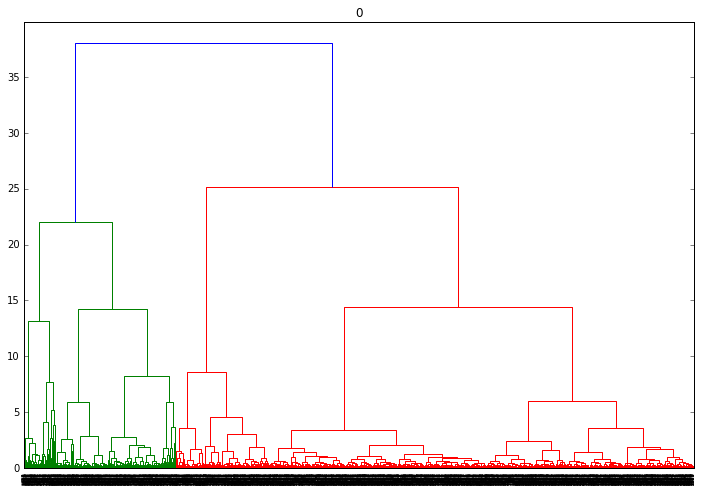

[1 2 3 4]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


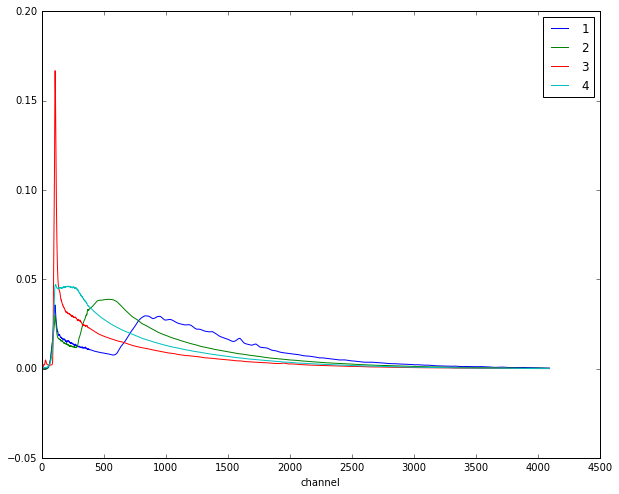

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


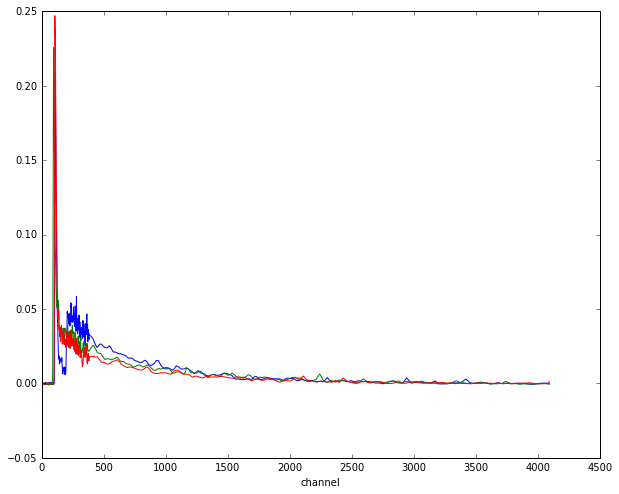

CPU times: user 25 s, sys: 3.35 s, total: 28.4 s
Wall time: 29.4 s


In [13]:
%%time
try:
    for batch_number, waveform in enumerate(data_loader):
        average = []
        average2 = []
        average3 = []
        average4 = []
        average5 = []
#         print(batch_number,label.size())
#         print(waveform.size())
        if batch_number == 1:
            break

        batch_size = waveform.size()[0]
#         print(batch_size)
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
#         print(batch_number)
#         print(feat[0].size())
        
        green = np.reshape(features[0].detach().numpy(),(batch_size,-1))
#         print(green.shape)
        Z = linkage(green, method="ward")
#         print(Z.shape)
#         print(Z)
        fig = plt.figure(figsize=(12, 8))
        dn = dendrogram(Z)
        plt.title(batch_number)
#         plt.savefig("ls.png")
        plt.show()
        
        clusters = fcluster(Z, 20, criterion='distance')
#         print(clusters.shape)
#         print(clusters)
        print(np.unique(clusters))
        
#         average = np.append(average,Z)
        
        for i, waveform_out in enumerate(feat[0]):
            
            red = waveform_out.detach().numpy()
#             red = np.reshape(waveform_out.detach().numpy(), (1,-1))
            blue = waveform_in[i].detach().numpy()
#             blue = normalize(waveform_in[i].detach().numpy(),axis=1)

#             print(i, red.shape,blue.shape)
#             print(red[0])
#             print(blue[0])

#             plt.figure()
#             plt.title("{}".format(clusters[i]))
# #             plt.plot(red[0],label="encoder output",alpha=0.7)
#             plt.plot(blue[0],label="encoder input",alpha=0.7)
#             plt.legend()
# #             plt.savefig("fig/autoencoder{}.png".format(i))
#             plt.show()
    
#             for k in range(len(np.unique(clusters))):
#                 if k==clusters[i]:
#                     plt.figure()
#                     plt.title("{}".format(k))
#                     plt.plot(red[0],label="encoder output",alpha=0.7)
#                     plt.plot(blue[0],label="encoder input",alpha=0.7)
#                     plt.legend()
# #                     plt.savefig("fig/{}_{}.png".format(k,i))
#                     plt.show()

            if clusters[i]==1:
                average.append(blue[0])
                
            if clusters[i]==2:
                average2.append(blue[0])
            
            if clusters[i]==3:
                average3.append(blue[0])
                
            if clusters[i]==4:
                average4.append(blue[0])
                
            if clusters[i]==5:
                average5.append(blue[0])
                
        dang = np.mean(average, axis=0)
        dang2 = np.mean(average2, axis=0)
        dang3 = np.mean(average3, axis=0)
        dang4 = np.mean(average4, axis=0)
        dang5 = np.mean(average5, axis=0)
        
        plt.figure(figsize=(10,8))
        plt.plot(dang,label="1")
        plt.plot(dang2,label="2")
        plt.plot(dang3,label="3")
        plt.plot(dang4,label="4")
#         plt.plot(dang5,label="5")
#         plt.xlim(50,200)
        plt.xlabel("channel")
        plt.legend()
#         plt.title(batch_number)
#         plt.savefig("ls3.png")
        plt.show()
        
        plt.figure(figsize=(10,8))
        plt.plot(average3[0])
        plt.plot(average3[1])
        plt.plot(average3[2])


#         plt.xlim(50,200)
        plt.xlabel("channel")
        plt.legend()
#         plt.title(batch_number)
#         plt.savefig("lsr.png")
        plt.show()
        
        
                    
#         Features[batch_number*1000:(batch_number+1)*1000] = feat[0]
        
        
#         print(Features.size())
    # db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
    # print(db.core_sample_indices_)
    # print(db.labels_)
        

except KeyboardInterrupt:
    print('Training ended early.')

In [ ]:
print(len(average)+len(average2)+len(average3)+len(average4))

dang = np.mean(average, axis=0)
dang2 = np.mean(average2, axis=0)
dang3 = np.mean(average3, axis=0)
dang4 = np.mean(average4, axis=0)

print(dang)
print(dang2)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(dang,label="1")
plt.plot(dang2,label="2")
plt.plot(dang3,label="3")
plt.plot(dang4,label="4")
plt.xlabel("channel")
plt.legend()
plt.show()


In [ ]:
%%reset

In [ ]:
print(average)
plt.figure()
dendrogram(average)
plt.show()

# plt.figure()
# print(len(average))
# for i in range(len(average)):
#     plt.figure()
#     plt.plot(average[np.random.randint(len(average))])
#     plt.show()
# plt.show()

# Testing Linkage directly on waveforms.

In [ ]:
%%time
un1 = []
un2 = []

try:
    for batch_number, waveform in enumerate(data_loader):

        if batch_number == 1:
            break
        batch_size = waveform.size()[0]
        green = np.reshape(waveform.detach().numpy(),(batch_size,-1))
        print(green.shape)
        Z = linkage(green, method="ward")
        print(Z.shape)
#         print(Z)
        fig = plt.figure(figsize=(12, 8))
        dn = dendrogram(Z)
        plt.show()
        
        clusters = fcluster(Z, 1.5, criterion='distance')
        print(clusters.shape)
        print(clusters)
        print(np.unique(clusters))
        
        for i, waveform_i in enumerate(waveform):
            if clusters[i]==1:
                un1.append(green[i])
                
            if clusters[i]==2:
                un2.append(green[i])
                
except KeyboardInterrupt:
    print('Training ended early.')

In [ ]:
sim1 = np.mean(un1,axis=0)
sim2 = np.mean(un2,axis=0)
print(sim1.size)
print(sim2.size)
plt.figure()
plt.plot(sim1)
plt.plot(sim2)
plt.xlabel("channel")
plt.show()

In [ ]:
plt.figure()
plt.plot(sim1)
plt.plot(sim2)
plt.xlabel("channel")
plt.xlim(70,300)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(generated[:2000].detach().numpy())
print(db.core_sample_indices_)
print(db.labels_)

In [ ]:
plt.hist(db.labels_)
plt.show()

In [ ]:
whos

# extracting filters/features

Use the protion of the Autoencoder transfer the trained weight to semi-half model of autoencoder.
Uses the output of the midlle layer of autoencoder and do a clustering on it.

The cluster number is a single vector(multi-class in keras?) representing the "output" of the group class.

# How to let this last layer of output automatically deduce itself.?
* save every sample output? how to make gives a supervised like methods output??

#Retrain the network but freeze all layer except for the last layer (clustering analysis layer). this can uses for LWRP studies, identify physical meaning of grouping. with it?

* understanding Neural Network, how to get layer-wise relevance propagation work for the last layer?

In [ ]:
# Discriminator
class Classifier(nn.Module):
    def __init__(self, input_chn, no_classes, kernel_size, 
                 no_filters, padding, maxpool, batch_size):
        super(Classifier, self).__init__()
        self.input_chn = input_chn
        self.no_classes = no_classes
        self.kernel_size = kernel_size
        self.padding = padding
        self.no_filters = no_filters
        self.maxpool = maxpool
        self.batch_size = batch_size
        
#         self.norm = nn.BatchNorm1d(input_chn)
        self.c1 = nn.Conv1d(input_chn ,no_filters ,kernel_size ,padding=padding )
        self.p1 = nn.MaxPool1d(maxpool ,padding )
        self.lr = nn.LeakyReLU(0.2)
        self.c2 = nn.Conv1d(no_filters, int(no_filters/2), kernel_size, padding=padding)
        self.p2 = nn.MaxPool1d(maxpool ,padding )       
        self.l1 = nn.Linear(4096,64)
        self.h1 = nn.Linear(64,64)
        self.out = nn.Linear(64, no_classes)  
        self.sg = nn.Sigmoid()
        
    def forward(self, inputs):
        
#         x = inputs.view(self.batch_size,1,-1)
#         x = self.norm(x)
        x = self.c1(x)
        x = self.lr(x)
        x = self.p1(x)
        x = self.c2(x)
        x = self.lr(x)
        x = self.p2(x)
        
        x = x.view(self.batch_size,-1)
        
        x = self.l1(x)
        x = self.lr(x)
        x = self.h1(x)
        x = self.out(x)
        outputs = self.sg(x)
        return outputs

# Clustering techniques
most likely DBSCAN don't require to specify number of clusters however this can explode making difficult to use, the best option for now

# Layer Wise Relevance Propagation Or similiar techniques
The purpose of understanding CNN, see which portion of data gives more importance, mostly likely create a new CNN using trained weights from autoencoder with the final layers self-created based of the results of clustering. This can allow us to treate this CNN as supervised technique like however in reality as it is based on purely unsupervised techniques. This supervised like technique allows us to use technique like layer wise relevance propagation to understand the CNN giving us insight of the working of features learned by the cNN.